In [292]:
import os,re
import time,pickle
from tqdm import *
from os.path import expanduser
import numpy as np
import sklearn
import matplotlib.pylab as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
home = expanduser('~')
os.chdir(os.path.join(home,'Documents','project','agu_data','repo','agu_data'))
from Data_Utils import *

import plotly.plotly as py
from plotly.tools import FigureFactory as FF

import gensim
from gensim import corpora, models, similarities
from pprint import pprint
model_saved = os.path.join(home,'Documents','project','agu_data','repo','Notebook','Models')
abstractf = os.path.join(model_saved,'gensim','abstract_bigram','abstract_bigram')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


American  Geophysical Union  (AGU) meeting  is a  geoscience conference
hold  each year  around Christmas  in San  Francisco. It  represents a
great opportunity for PhD students like  me to show off their work and
enjoy what the west coast has to offer. However, with  nearly 24 000 attendees,  AGU Fall Meeting is  also the
largest Earth  and space  science meeting  in the  world. As  such, it
represents an interesting data set to dive into the geoscience academic
world.  

In this post, I explore different information retrieval techniques taken from the field of natural language processing to explore the hidden patterns in the submitted abstract collection in 2015.

The objective is two fold:

- Identify semantic-based similarities between the contribution proposed at AGU to build a recommandation system based on the abstract content.
- Propose for each contributor a list of potential collaborators based on the authors of the papers proposed by our recommendantion system.

Different natural language processing tools are available in python to achieve this goal and after trying [sklearn](http://scikit-learn.org/stable/), I decided to settle on [gensim](https://radimrehurek.com/gensim/) which has partilarly fast and effective implementations to work with large dataset (~20000 abstracts here).

The basic stage, which I'll detail in the following are

- Cleaning the data.
- Construct a valid embedding for the corpus.
- Compute the similarities between the document within this embedding.

## Data cleaning

Data cleaning is an essential step for our recommendation system. Indeeed, our model is going to use the resulting corpus to build a consistent embedding of the abstracts and we don't want him to focus on unnecessary details. In particular, I used the module **unicodedata** to remove non-ascii caracters from the corpus.

In [331]:
data = get_all_data('agu2015')
sources = [df for df in data if (''.join(df.title) != "") and (df.abstract != '') and (len(df.abstract.split(' '))>100)]
sections = [df.section for df in sources]
abstracts = get_clean_abstracts(sources)
titles = get_clean_titles(sources)

In the following, I'll use on of my contributions to evaluate the consistency of our recommendation system. 

In [145]:
def name_to_idx(sources,name):
    ''' From an authors, return the list of contributions '''
    contrib = [f for f in sources if name in f.authors.keys()]
    return [sources.index(elt) for elt in contrib]
    
my_contrib = name_to_idx(sources,'Clement Thorey')
print 'Title : %s'%(titles[my_contrib[0]])
print 'Abstract : %s'%(abstracts[my_contrib[0]])+'\n\n'

Title :  Floor-Fractured Craters through Machine Learning Methods
Abstract : Floor-fractured craters are impact craters that have undergone post impact deformations. They are characterized by shallow floors with a plate-like or convex appearance, wide floor moats, and radial, concentric, and polygonal floor-fractures. While the origin of these deformations has long been debated, it is now generally accepted that they are the result of the emplacement of shallow magmatic intrusions below their floor. These craters thus constitute an efficient tool to probe the importance of intrusive magmatism from the lunar surface. The most recent catalog of lunar-floor fractured craters references about 200 of them, mainly located around the lunar maria Herein, we will discuss the possibility of using machine learning algorithms to try to detect new floor-fractured craters on the Moon among the 60000 craters referenced in the most recent catalogs. In particular, we will use the gravity field provided

May be a bit of context can be usefull here. My PhD was about the detection and the characterization of magmatic intrusions on terrestrial planets. For those who wonder, a magmatic intrusion is a large volume of magma which, instead of rising until the surface and form a volcano, emplace at depth beneath the surface (less than a few km) where it cools and solidifies. On Earth, erosion and weathering can sometimes expose these intrusions at the surface. This is the case for instance in the henry mountains

![Example of an exposed magmatic intrusion in the Henry Mountains](https://upload.wikimedia.org/wikipedia/commons/a/a6/Laccolith_Montana.jpg)

My contributions at AGU deals with the detection and the characterization of those intrusions.

The first one is about the detection of a specific family of magmatic intrusions on the Moon which we call crater-centered intrusions. Particularly, those are magmatic intrusions that have emplaced and solidify beneath large impact craters (>20km in diameter) at the surface of the Moon. Consequently, these crater are heavily deformed due to the magmatic intrusion with large network of fracture crossing their floor.  In this contribution, I use machine learning techniques to try to automatically detect potential floor-fractured craters among 60000 referenced lunar impact craters. 


## Bag of Words model

The basic representation for a corpus of text document is called a [Bag of Word (BoW) model](https://en.wikipedia.org/wiki/Bag-of-words_model). This model looks at all the words in the corpus and first build a dictionary referencing all the words it has seen. Then, for each document in the corpus, in simply count how many times each word of the dictionary appears in this particular document. The result is a large matrix, each row is a text document, each columns is a particular word of the dicitonarry, that is, as you can guess, mostly fill with zeros. 

### Tokenizer

Under the hood, the BoW model assume an efficient tokenizer function which is able to split each document it its own set of tokens. A vanilla tokenizer function looks like this

In [23]:
def tokenizer(text):
    return text.split(' ')

which simply look at each document and split it in a list of tokens according to the white spaces in the document. In the following, I'll use a slightly more evolve version of this tokenizer which I embedded in a Tokenizer class.

It use the [nltk](http://www.nltk.org/) library to first break each document (abstract) into sentences, then words.
Then using reg expression, it keeps only suitable tokens. In particular,

- `^[a-z]+$` keeps only words made of letters.
- `^[a-z][\d]$` selects tokens that have 2 characters, one letter, one number (molecule stuff).
- `^[a-z][\d][a-z]$` selects tokens that have 3 characters, one letter, one number, one letter (again molecule stuff).
- `^[a-z]{3}[a-z]*-[a-z]*$` includes some tokens that are composed of two words joined by -.

Next, I use a stopword list provide by **nltk** to filter out all the common word of the english language. Indeed, stopwords are words like 'the' or 'as' that are most likely present everywhere but do not carry meaningfull information in our purpose. This tokenizer also incorporates a last stage of stemming for each token. Stemming is the term used in information retrieval to describe the process for reducing words to their word stem, base or root form—generally a written word form. 

For instance, imagine this document

'Here we show that running is good for health. Indeed runner are quite healthy. Though they have runned a lot in their runly life, they are quite good at that.'

Clearly, this document is all about running! Nevertheless, without the stemming part in our tokenizer, 'runly' will have the same weight than 'good', equal to 1. In contrast, the stemming will reduce 'running', 'runned', 'runly' and 'runner' to their stem, namely 'run'. The word 'run' in the BoW will then have a weight of 4 for this document clearly underlying its importance ! I use the so-called SnowballStemmer included in the library **nltk** for stemming. 

Finally, in addition to these simple stem tokens, I also add the possibility to use bi-grams to the dictionary, i.e. all the combinations of two consecutive stem-words in each abstracts which is a common practise when using BoW model. We will see why later.


In [238]:
class Tokenizer(object):

    def __init__(self, add_bigram):
        self.add_bigram = add_bigram
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.stemmer = nltk.stem.snowball.SnowballStemmer("english")

    def bigram(self, tokens):
        if len(tokens) > 1:
            for i in range(0, len(tokens) - 1):
                yield tokens[i] + '_' + tokens[i + 1]

    def tokenize_and_stem(self, text):
        tokens = [word.lower() for sent in nltk.sent_tokenize(text)
                  for word in nltk.word_tokenize(sent)]
        filtered_tokens = []
        bad_tokens = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw
        # punctuation)
        for token in tokens:
            if re.search('(^[a-z]+$|^[a-z][\d]$|^[a-z]\d[a-z]$|^[a-z]{3}[a-z]*-[a-z]*$)', token):
                filtered_tokens.append(token)
            else:
                bad_tokens.append(token)
        filtered_tokens = [
            token for token in filtered_tokens if token not in self.stopwords]
        stems = map(self.stemmer.stem, filtered_tokens)
        if self.add_bigram:
            stems += [f for f in self.bigram(stems)]
        return map(str, stems)


### Dictionary

Then, the next step is to build the dictionary. **Gensim** is built in a memory-friendly fashion. Therefore, instead of loading the whole corpus into memory, tokenizing and stemming everything and see what remains, it allows us to build the dictionary document by document, with one document in memory at a time. 

In [279]:
abstractf = os.path.join(model_saved,'gensim','abstract','abstract')
build = False
if build:
    # First, write the document corpus on a txt file, one document perline.
    write_clean_corpus(abstracts,abstractf+'data.txt')
    tokeniser = Tokenizer(False)
    # Next create the dictionary by iterating of the abstract, one per line in the txt file
    dictionary = corpora.Dictionary(tokenizer.tokenize_and_stem(line) for line in open(abstractf+'.txt')) 
    dictionary.save(abstractf+'_raw.dict')
else:
    tokeniser = Tokenizer(False)
    dictionary = corpora.Dictionary.load(abstractf+'_raw.dict')

The resulting dictionary contains 70150 tokens. While we could work out a BoW model from there, it is often a good idea to remove extreme tokens. For instance, a token appearing in only 1 abstract is not going to help us build a recommandation system. Similarly, a token that appears in all the documents is not likely to carry meaningfull information neither for our purpose. I thereferore decided to remove all tokens that appear in less than 5 abstracts and in more than 80% of them. Note that creating the dictionarry can take up to 1 minute on my laptop which make serialization a good idea.

In [284]:
build = False
if not os.path.isfile(abstractf+'_raw.dict') or build:
    dictionary =  corpora.Dictionary.load(abstractf+'_raw.dict')
    dictionary.filter_extremes(no_below=5,no_above=0.80,keep_n=200000)
    dictionary.id2token = {k:v for v,k in dictionary.token2id.iteritems()}
    dictionary.save(abstractf+'.dict')
else:
    dictionary = corpora.Dictionary.load(abstractf+'.dict')
    dictionary.id2token = {k:v for v,k in dictionary.token2id.iteritems()}

In [285]:
len(dictionary)

14669

### BoW representation

Now we have the dictionary, it is actually easy to obtain the BoW representation of any document. We just have to tokenize the document using the same function used to build the dictionary and count the occurence of each word. Each dictionary in **gensim** possess a method **doc2bow** which does exactly that and return the representation as a sparse vector, i.e. a vector where only words that have a count different from zero are returned.

For instance, the BoW representation of my first abstract is 

In [311]:
my_contrib_bow = dictionary.doc2bow(tokenizer.tokenize_and_stem(abstracts[my_contrib[0]]))
df = [f+(dictionary.id2token[f[0]],) for f in my_contrib_bow]
df = pd.DataFrame(df,columns = ['id','Count','Token']).sort_values(by='Count',ascending = False)
df.index= range(len(df))
table = FF.create_table(df.head(5))
py.iplot(table, filename='Bow_0')

where the result are presented as a pandas dataframe for clarity and each id has been identified to its proper token. Indeed, each dictionary assign a unique integer id to all tokens appearing in the dictionary. Note that the BoW representation of my first abstract on Floor-Fractured craters, which underlies the importance of the stem token crater, lunar, intrusion, floor and classifi, is farely accurate.

By converting each abstract of the corpus in this doc2bow method, we can obtain the BoW representation of our full corpus. A careless memory way to do that is to just iterate the doc2bow method of our dictionary over the abstract list we have defined at the beginning. Nevertheless, this would end up storing the whole doc2bow representation into memory as a huge matrice. Instead, **gensim** has been designed such that it only requires that a corpus must be able to return one document vector (for instance, the doc2bow representation of the document here) at a time. We then define the BoW corpus as a sprecific object `MyCorpus` where the method `__iter__` is consistently defined to iter and transform each line of the txt file where the abstracts content is stored.

In [287]:
class MyCorpus(Tokenizer):

    def __init__(self, name, add_bigram):
        super(MyCorpus, self).__init__(add_bigram)
        self.name = name

    def load_dict(self):
        if not os.path.isfile(self.name + '.dict'):
            print 'You should build the dictionary first !'
        else:
            setattr(self, 'dictionary',
                    corpora.Dictionary.load(self.name + '.dict'))

    def __iter__(self):
        for line in open(self.name + '_data.txt'):
            # assume there's one document per line, tokens separated by
            # whitespace
            yield self.dictionary.doc2bow(self.tokenize_and_stem(line))

    def __str__(self, n):
        for i, line in enumerate(open(self.name + '_data.txt')):
            print line
            if i > n:
                break

In [289]:
build = False
if build:
    bow_corpus = MyCorpus(abstractf,False)
    corpora.MmCorpus.serialize(abstractf+'.mm',bow_corpus)
else:
    bow_corpus = corpora.MmCorpus(abstractf+'.mm')

`MyCorpus` also posseses a print method which return the BoW representation of the first n document. Again, the return representation is parsed, i.e. it contains only the counts for non-zero element

In [125]:
bow_corpus.__str__()

'MmCorpus(21935 documents, 116821 features, 3556203 non-zero entries)'

### Recommendation 

In the BoW representation of our corpus, each abstract is a point in a high-dimensional embedding (a 14669 dimensions embedding exactly). The *distance* or the *similarity* between one abstract and the rest of the corpus, according to some metrics, can then be used to compare different contributions together and then, to provide a recommendation list for a specific query. 

The euclidean distance is the more natural choice for the similarity measure. Given two vectors  $\vec{a}$ and $\vec{b}$, it is equal to 
$$d(\vec{a},\vec{b}) = \sqrt{(\vec{b}- \vec{a})\cdot(\vec{b}- \vec{a}) }$$


However, we'd like our distance to be independant of the magnitude of the difference between two vectors. For instance, we'd like to identify as similar two abstracts which contain exactly the same tokens even if their occurence differs significantly. The euclidean distance clearly does not have this property.

Accordingly, a more reliable measure for our purpose is called "the cosine similarity". For two vectors, $\vec{a}$ and $\vec{b}$, the cosine similarity $d$ is defined as :

$$ d(\vec{a},\vec{b})= \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|} = \cos(\vec{a},\vec{b})$$

In particular, this similarity measure is the dot product of the two normalized vector and hence, depends only on the angle between the two vectors (which is were its name comes from ;). It ranges from -1 when two vectors point in the opposite direction to 1 when they point in the same direction.

To compute the similarity of one query against our BoW representation, the natural procedure is to first transform our sparse representation into its dense equivalent, i.e. a matrice where the number of lines correspond to the number of tokens in the dictionary and the number of columns to the number of abstracts in the corpus. Then, we column normalize the matrice such that each document correspond to a unit vector in the representation space. Finaly, we take the dot product of the transposed matrice with the desired normalized query to get the cosine similarity agaist all documents in the corpus.

**Gensim** contains efficient utility functions to help converting from/to numpy matrice and therefore, this translates to

In [127]:
# First load the corpus and the dicitonary
bow_corpus = corpora.MmCorpus(abstractf+'.mm')
dictionary = corpora.Dictionary.load(abstractf+'.dict')
# Transform our sparse representation into dense
numpy_matrix = gensim.matutils.corpus2dense(bow_corpus, num_terms=len(dictionary))
# Normalize each abstract in the corpus
normalized_matrix = numpy_matrix/np.sqrt(np.sum(numpy_matrix*numpy_matrix,axis=0))
# Take the dot product of the resulting matrice with query to get the relevant cosine similarity
score = np.dot(normalized_matrix.T,normalized_matrix[:,my_contrib[0]])

In [297]:
results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
r

,Cosine-Similarity,Title
0,1.00000119209,Floor-Fractured Craters through Machine Learn...
1,0.397855073214,Preliminary Geological Map of the Ac-H-2 Coni...
2,0.392508625984,The collisional history of dwarf planet Ceres...
3,0.375328063965,Structural and Geological Interpretation of P...
4,0.374307662249,Lunar Crater Interiors with High Circular Pol...
5,0.373661845922,Morphologic Analysis of Lunar Craters in the ...
6,0.372885197401,Initial Results from a Global Database of Mer...
7,0.364291280508,Katabatically Driven Downslope Windstorm-Type...
8,0.334211647511,Origin of the rock abundance anomaly at Tsiol...
9,0.332181990147,Comparing Radar and Optical Data Sets of Luna...


The cosine-similarity of the query against itself returns 1, which in itself is reassuring! The cosine-similarity then drops below 0.5. 

## TF-IDF representation

One of the problem with the BoW representation is that it often puts too much weights on common words of the corpus. Indeed, while we remove most common words in english, i.e. the stopwords, word like 'present', 'show' of whatever is commonly use in the writing-abstract vocabulary can add some noise in regards to our purpose. In particular here, we would like to put more weights on tokens that make each abstract specific.

A common way to do this is to use a **Tf-Idf** normalization to re-weiht each count in the BoW representation by the frequency of the token in the whole corpus. **Tf** means term-frequency while **Tf–Idf** means term-frequency times inverse document-frequency. This way, the weight of common tokens in the corpus will be significantly lowered.

This implentation is available is **gensim** and can be easily combined with the BoW representation to get the representation of the corpus in the tf-idf space.


In [129]:
build = False
if not os.path.isfile(abstractf+'_tfidf.mm') or build:
    # First load the corpus and the dicitonary
    bow_corpus = corpora.MmCorpus(abstractf+'.mm')
    dictionary = corpora.Dictionary.load(abstractf+'.dict')
    # Initialize the tf-idf model
    tfidf = models.TfidfModel(bow_corpus)
    # Compute the tfidf of the corpus itself
    tfidf_corpus = tfidf[bow_corpus]
    # Serialize both for reuse
    tfidf.save(abstractf+'_tfidf.model')
    corpora.MmCorpus.serialize(abstractf+'_tfidf.mm',tfidf_corpus)
else:
    tfidf = models.TfidfModel.load(abstractf+'_tfidf.model')
    tfidf_corpus = corpora.MmCorpus(abstractf+'_tfidf.mm')

In [130]:
# Transform our sparse representation into dense
numpy_matrix = gensim.matutils.corpus2dense(tfidf_corpus, num_terms=len(dictionary))
# Normalize each abstract in the corpus
normalized_matrix = numpy_matrix/np.sqrt(np.sum(numpy_matrix*numpy_matrix,axis=0))
# Take the dot product of the resulting matrice with query to get the relevant cosine similarity
score = np.dot(normalized_matrix.T,normalized_matrix[:,my_contrib[0]])
results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
results.head(10)

,Cosine-Similarity,Title
0,1.00000011921,Floor-Fractured Craters through Machine Learn...
1,0.306450784206,Katabatically Driven Downslope Windstorm-Type...
2,0.301954627037,The collisional history of dwarf planet Ceres...
3,0.296527802944,Lunar Crater Interiors with High Circular Pol...
4,0.293061137199,Morphologic Analysis of Lunar Craters in the ...
5,0.291249215603,Structural and Geological Interpretation of P...
6,0.288441091776,Initial Results from a Global Database of Mer...
7,0.287416309118,Preliminary Geological Map of the Ac-H-2 Coni...
8,0.260232925415,Hydrological Evolution and Chemical Structure...
9,0.256310105324,Comparing Radar and Optical Data Sets of Luna...


In [316]:
abstractf = os.path.join(model_saved,'gensim','abstract','abstract')
def recom(abstractf,name):
    dictionary = corpora.Dictionary.load(abstractf+'.dict') 
    corpus = corpora.MmCorpus(abstractf + '_'+str(name)+'.mm')
    index = similarities.MatrixSimilarity.load(abstractf+'_'+str(name)+'.index')
    score = index[corpus[my_contrib[0]]]
    results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['CosineSimilarity','Title'])
    return results
df = recom(abstractf,'lsi')
for i,row in df.iterrows():
    print 'Recom %d - Cosine: %1.3f - Title: %s'%(i+1,float(row.CosineSimilarity),row.Title)
    if i>8:
        break

Recom 1 - Cosine: 1.000 - Title:  Floor-Fractured Craters through Machine Learning Methods
Recom 2 - Cosine: 0.827 - Title:  Lunar Crater Interiors with High Circular Polarization Signatures
Recom 3 - Cosine: 0.822 - Title:  Morphologic Analysis of Lunar Craters in the Simple-to-Complex Transition
Recom 4 - Cosine: 0.815 - Title:  Continuous Bombardment  Effect of Small Primary and Secondary Impacts on the Lunar Regolith
Recom 5 - Cosine: 0.813 - Title:  Structural and Geological Interpretation of Posidonius Crater on the Moon
Recom 6 - Cosine: 0.780 - Title:  Comparing Radar and Optical Data Sets of Lunar Impact Crater Ejecta
Recom 7 - Cosine: 0.776 - Title:  Katabatically Driven Downslope Windstorm-Type Flows on the Inner Sidewall of Arizona's Barringer Meteorite Crater
Recom 8 - Cosine: 0.763 - Title:  The collisional history of dwarf planet Ceres revealed by Dawn
Recom 9 - Cosine: 0.759 - Title:  Preliminary Geological Map of the Ac-H-2 Coniraya Quadrangle of Ceres  An Integrated M

This indeed produces a slight improve of the score

## Latent Semantic Analysis (LSA) or (LSI)

Latent Semantic Analysis (LSA) or Indexing (LSI) is a common method in information retrieval to reduce the dimension of the representation space. The idea behind it is that a lot of the dimensions in the BoW model or equivalently, the Tf-idf model are redundant. For instance, the words machine and learning are more likely two occur together. Therefore, shrinking these two dimensions to only one which is form by a linear combination of the token machine and learning would reduce the dimension without any loss of information. More generally, the Latent Semantic Analysis aims to reduce the dimensions while keeping as much information possible present in the higher dimensal space by identifying deep semantic pattern in the corpus.

To identify this semantic structure, Latent Semantic Analysis used a linear algebra method called [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Formally, the SVD is able to identify a consistent lower-dimensional approximation of the higher-dimensional tfidf space. **Gensim** implements the Latent Semantic Analysis under a model called `LsiModel` which can be used on top of our previous representation easily.

In [131]:
build = False
if not os.path.isfile(abstractf+'_lsi.mm') or build:
    # First load the corpus and the dicitonary
    tfidf_corpus = corpora.MmCorpus(abstractf+'_tfidf.mm')
    dictionary = corpora.Dictionary.load(abstractf+'.dict')
    # Initialize the LSI model
    lsi = models.LsiModel(tfidf_corpus,id2word=dictionary, num_topics=500)
    # Compute the tfidf of the corpus itself
    lsi_corpus = lsi[tfidf_corpus]
    # Serialize both for reuse
    lsi.save(abstractf+'_lsi.model')
    corpora.MmCorpus.serialize(abstractf+'_lsi.mm',lsi_corpus)
else:
    lsi = models.LsiModel.load(abstractf+'_lsi.model')
    lsi_corpus = corpora.MmCorpus(abstractf+'_lsi.mm')

In [132]:
# Transform our sparse representation into dense
numpy_matrix = gensim.matutils.corpus2dense(lsi_corpus, num_terms=len(dictionary))
# Normalize each abstract in the corpus
normalized_matrix = numpy_matrix/np.sqrt(np.sum(numpy_matrix*numpy_matrix,axis=0))
# Take the dot product of the resulting matrice with query to get the relevant cosine similarity
score = np.dot(normalized_matrix.T,normalized_matrix[:,my_contrib[1]])
results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
results.head(10)

,Cosine-Similarity,Title
0,1.0,A General Model for Shallow Magmatic Intrusions
1,0.517181456089,Floor-Fractured Craters through Machine Learn...
2,0.501089692116,Periodicity of Klaueas Dike Intrusions
3,0.484440237284,Geophysical Survey and Detailed Geologic Mapp...
4,0.482387363911,New Insights into the 2009 Harrat Lunayyir Di...
5,0.46358448267,Post-Emplacement Behaviour of Magma Reservoirs
6,0.434896945953,The Structure and Evolution of Volcanic Plumb...
7,0.419506818056,Stress Change on Faults at Kilauea Volcano fr...
8,0.418333232403,The response of visco-elastic crust and mantl...
9,0.416936188936,"The Sills of Guaymas Basin, Gulf of Californi..."


In [313]:
abstractf = os.path.join(model_saved,'gensim','abstract','abstract')
def recom(abstractf,name):
    dictionary = corpora.Dictionary.load(abstractf+'.dict') 
    corpus = corpora.MmCorpus(abstractf + '_'+str(name)+'.mm')
    index = similarities.MatrixSimilarity.load(abstractf+'_'+str(name)+'.index')
    score = index[corpus[my_contrib[0]]]
    results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
    print results.head(10)

In [315]:
df = recom(abstractf,'lsi')

  Cosine-Similarity                                              Title
0     1.00000011921   Floor-Fractured Craters through Machine Learn...
1    0.827089130878   Lunar Crater Interiors with High Circular Pol...
2    0.822211742401   Morphologic Analysis of Lunar Craters in the ...
3    0.814611911774   Continuous Bombardment  Effect of Small Prima...
4     0.81260228157   Structural and Geological Interpretation of P...
5    0.780470311642   Comparing Radar and Optical Data Sets of Luna...
6     0.77597630024   Katabatically Driven Downslope Windstorm-Type...
7    0.763461530209   The collisional history of dwarf planet Ceres...
8     0.75903236866   Preliminary Geological Map of the Ac-H-2 Coni...
9    0.748711466789   Origin of the rock abundance anomaly at Tsiol...


In [135]:
results.Title.tolist()[:50]

[' A General Model for Shallow Magmatic Intrusions',
 ' Floor-Fractured Craters through Machine Learning Methods',
 ' Periodicity of Klaueas Dike Intrusions',
 ' Geophysical Survey and Detailed Geologic Mapping of an Eroded Stratovolcanos Central Intrusive Complex, Summer Coon, Co.',
 ' New Insights into the 2009 Harrat Lunayyir Dike Intrusion from InSAR, Stress Calculations and Analog Experiments',
 ' Post-Emplacement Behaviour of Magma Reservoirs',
 ' The Structure and Evolution of Volcanic Plumbing Systems in Fold-and-Thrust Belts  a Case Study of a Miocene Intrusive Complex in the Neuquen Andes, Argentina',
 ' Stress Change on Faults at Kilauea Volcano from an Intrusive Event in April-May, 2015',
 ' The response of visco-elastic crust and mantle to the inflation/deflation of magma chamber',
 ' The Sills of Guaymas Basin, Gulf of California  Their Distribution and Seismic Estimates of Their Thickness and Alteration of Intruded Sediments',
 ' Geophysical Interpretation of Mantle Magm

In [141]:
lsi.show_topics(2)

[u'0.119*"model" + 0.116*"water" + 0.108*"climat" + 0.103*"soil" + 0.097*"chang" + 0.093*"data" + 0.086*"ice" + 0.083*"surfac" + 0.079*"temperatur" + 0.077*"region"',
 u'-0.333*"fault" + -0.260*"earthquak" + -0.213*"seismic" + 0.196*"soil" + -0.150*"slip" + 0.150*"climat" + -0.129*"mantl" + 0.125*"water" + -0.116*"veloc" + -0.109*"plate"']

In [136]:
index_lsi = similarities.MatrixSimilarity(lsi_corpus)
index_lsi.save(abstractf+'_lsi.index')

In [207]:
os.getcwd()

'/Users/thorey/Documents/project/agu_data/repo/agu_data'

In [219]:
abstractf = os.path.join(model_saved,'gensim','test','test')

In [231]:
raw_dictionary = corpora.Dictionary.load(abstractf+'_raw.dict') 
dictionary = corpora.Dictionary.load(abstractf+'.dict') 
bow_corpus = corpora.MmCorpus(abstractf + '_bow.mm')
bow_index= similarities.SparseMatrixSimilarity.load(abstractf+'_bow.index')

In [232]:
raw_dictionary.token2id

{u'locat_degre': 6578,
 u'temperatur_monitor': 14807,
 u'electron_distribut': 14331,
 u'limb_flood': 5595,
 u'conduct_annual': 12433,
 u'present_observ': 11529,
 u'vast_larger': 3791,
 u'mass_densiti': 10368,
 u'yellow': 9302,
 u'contract_nation': 375,
 u'four': 180,
 u'output_thermomechan': 17262,
 u'radio_emiss': 3721,
 u'mani_pre-columbian': 17776,
 u'land_ice': 17623,
 u'calv_strong': 14146,
 u'evalu_even': 13261,
 u'profil': 4712,
 u'scale_minut': 13,
 u'recess_paramet': 6188,
 u'distribut_default': 4883,
 u'complex_japan': 541,
 u'coexist_brittl': 4061,
 u'state_colorado': 5952,
 u'accret': 11802,
 u'sever_geochem': 4238,
 u'concept_connect': 2129,
 u'process_general': 7881,
 u'fm_hydrodynam': 15137,
 u'sediment_influx': 9514,
 u'associ_implic': 15028,
 u'stress_within': 15920,
 u'throughout_whole': 4659,
 u'ozon_upper': 16854,
 u'simul_perform': 13587,
 u'digit': 7174,
 u'function_cloud': 16681,
 u'log_acoust': 11315,
 u'gravit_outer': 15433,
 u'also_regul': 1884,
 u'pigment': 1

In [235]:
from Data_Utils import Tokenizer
tokenizer = Tokenizer(True)

In [237]:
vec_bow = dictionary.doc2bow(tokenizer.tokenize_and_stem(abstracts[0]))
bow_index[vec_bow]

array([ 0.9999994 ,  0.17107144,  0.07028911,  0.04648431,  0.11395319,
        0.09038769,  0.05123566,  0.04243489,  0.04367088,  0.02460991,
        0.12807788,  0.03951119,  0.19735935,  0.09979749,  0.0716353 ,
        0.07484812,  0.13644207,  0.15803227,  0.27943572,  0.12766138], dtype=float32)

In [246]:
abstractf
recom('bow')

      Cosine-Similarity                                              Title
0         1.00000119209   Floor-Fractured Craters through Machine Learn...
1        0.397855073214   Preliminary Geological Map of the Ac-H-2 Coni...
2        0.392508625984   The collisional history of dwarf planet Ceres...
3        0.375328063965   Structural and Geological Interpretation of P...
4        0.374307662249   Lunar Crater Interiors with High Circular Pol...
5        0.373661845922   Morphologic Analysis of Lunar Craters in the ...
6        0.372885197401   Initial Results from a Global Database of Mer...
7        0.364291280508   Katabatically Driven Downslope Windstorm-Type...
8        0.334211647511   Origin of the rock abundance anomaly at Tsiol...
9        0.332181990147   Comparing Radar and Optical Data Sets of Luna...
10       0.326895862818     Processes Modifying Cratered Terrains on Pluto
11       0.318992644548   An Ice-rich Mantle on Ceres from Dawn Mapping...
12       0.306114643812  

In [269]:
abstractf = os.path.join(model_saved,'gensim','abstract','abstract')
def recom(abstractf,name):
    dictionary = corpora.Dictionary.load(abstractf+'.dict') 
    corpus = corpora.MmCorpus(abstractf + '_'+str(name)+'.mm')
    index = similarities.MatrixSimilarity.load(abstractf+'_'+str(name)+'.index')
    score = index[corpus[my_contrib[0]]]
    results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
    print results.head(10)

In [270]:
recom(abstractf,'bow')

  Cosine-Similarity                                              Title
0    0.999999463558   Floor-Fractured Craters through Machine Learn...
1    0.465053528547   Preliminary Geological Map of the Ac-H-2 Coni...
2    0.459065884352   The collisional history of dwarf planet Ceres...
3    0.452919542789   Structural and Geological Interpretation of P...
4    0.433349221945   Initial Results from a Global Database of Mer...
5     0.43091493845   Lunar Crater Interiors with High Circular Pol...
6    0.426743030548   Morphologic Analysis of Lunar Craters in the ...
7    0.419104278088   Katabatically Driven Downslope Windstorm-Type...
8    0.393045037985   Origin of the rock abundance anomaly at Tsiol...
9    0.386097788811   Comparing Radar and Optical Data Sets of Luna...


In [272]:
recom(abstractf,'tfidf')

  Cosine-Similarity                                              Title
0     1.00000011921   Floor-Fractured Craters through Machine Learn...
1    0.488451182842   Structural and Geological Interpretation of P...
2    0.474600285292   The collisional history of dwarf planet Ceres...
3    0.461971431971   Katabatically Driven Downslope Windstorm-Type...
4     0.44981071353   Initial Results from a Global Database of Mer...
5     0.44743385911   Hydrological Evolution and Chemical Structure...
6    0.443795830011   Lunar Crater Interiors with High Circular Pol...
7     0.43740221858   Preliminary Geological Map of the Ac-H-2 Coni...
8    0.424199879169   Morphologic Analysis of Lunar Craters in the ...
9    0.408888667822     Processes Modifying Cratered Terrains on Pluto


In [273]:
recom(abstractf,'lsi')

  Cosine-Similarity                                              Title
0     1.00000011921   Floor-Fractured Craters through Machine Learn...
1    0.827089130878   Lunar Crater Interiors with High Circular Pol...
2    0.822211742401   Morphologic Analysis of Lunar Craters in the ...
3    0.814611911774   Continuous Bombardment  Effect of Small Prima...
4     0.81260228157   Structural and Geological Interpretation of P...
5    0.780470311642   Comparing Radar and Optical Data Sets of Luna...
6     0.77597630024   Katabatically Driven Downslope Windstorm-Type...
7    0.763461530209   The collisional history of dwarf planet Ceres...
8     0.75903236866   Preliminary Geological Map of the Ac-H-2 Coni...
9    0.748711466789   Origin of the rock abundance anomaly at Tsiol...


In [259]:
def recom(abstractf,name):
    dictionary = corpora.Dictionary.load(abstractf+'.dict') 
    corpus = corpora.MmCorpus(abstractf + '_'+str(name)+'.mm')
    index = similarities.MatrixSimilarity.load(abstractf+'_'+str(name)+'.index')
    score = index[corpus[my_contrib[0]]]
    results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
    print results.head(10)

In [140]:
vec_bow = dictionary.doc2bow(bow_corpus.tokenize_and_stem('machine learning prediction superived'))
vec_tfidf = tfidf[vec_bow]
vec_lsi = lsi[vec_tfidf]
score = index_lsi[vec_lsi]
results = pd.DataFrame(np.stack((np.sort(score)[::-1],np.array(titles)[np.argsort(score)[::-1]])).T,
                       columns = ['Cosine-Similarity','Title'])
results.head(10)

,Cosine-Similarity,Title
0,0.587944567204,Advances in Climate Informatics Accelerating...
1,0.4658434093,Blue Sky Funders Forum - Advancing Environmen...
2,0.458382487297,Machine Learning for Flood Prediction in Goog...
3,0.456735908985,The World Climate Exercise Is (Simulated) Ex...
4,0.447082310915,Integrating Scientific Inquiry into an Underg...
5,0.445350646973,Harnessing the power of mobile technologies f...
6,0.436387091875,Online Experiential Learning Effective Appli...
7,0.412569195032,Education Through Exploration Evaluating the...
8,0.387512564659,Going To The Field Immersing Student Researc...
9,0.384967625141,Assessing the use of Machine Learning Algorit...


In [145]:
from sklearn.manifold import TSNE

In [156]:
lsi_corpus.length

In [ ]:
tsne = TSNE(n_components=2, random_state=0,metric='cosine')
X = gensim.matutils.corpus2dense(lsi_corpus, num_terms=lsi.num_terms)
X_tsne = tsne.fit_transform(X)

In [155]:
tfidf_corpus

In [322]:
from tsne import bh_sne
lsi_corpus = corpora.MmCorpus(abstractf + '_lsi.mm')
X = gensim.matutils.corpus2dense(lsi_corpus, num_terms=lsi_corpus.num_terms)

In [327]:
x_data = np.asarray(X).astype('float64')

In [337]:
x_data.shape

(500, 21935)

In [338]:
vis_data = bh_sne(x_data.T)

In [355]:
import seaborn as sns

/Users/thorey/miniconda2/envs/agu_data/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning:

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.



In [360]:
color = sns.

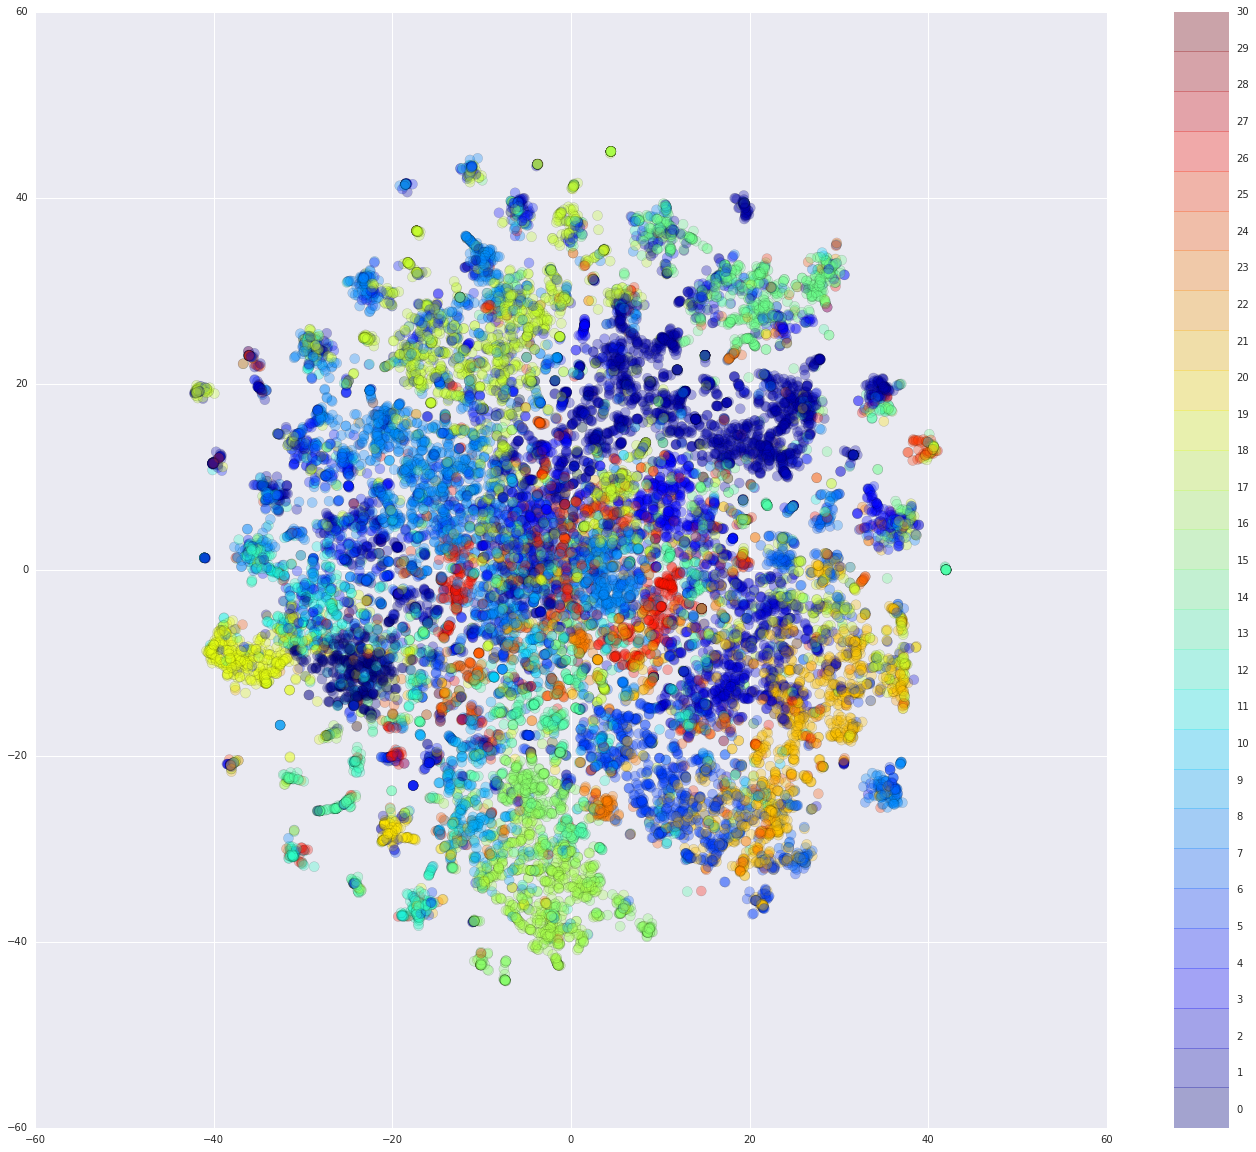

In [365]:
fig = plt.figure(figsize = (24,20))
ax = plt.subplot(111)
y_data = map(lambda x:dict_section[x],sections)

# plot the result
vis_x = vis_data[:, 0]
vis_y = vis_data[:, 1]

plt.scatter(vis_x, vis_y, c=y_data, cmap=plt.cm.get_cmap("jet", 28),alpha = 0.3,s =100)
plt.colorbar(ticks=range(130))
plt.clim(-0.5, 30)

In [344]:
set(y_data)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26}

In [334]:
dict_section = dict(zip(set(sections),range(len(set(sections)))))
y_data = map(lambda x:dict_section[x],sections)

In [336]:
len(sections_id),len(vis_x)

(21935, 500)